In [1]:
import sys
sys.path.append("./../..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

#
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
#
from effcn.models_mnist import CapsNet, CapsNetCross,EffCapsNetCross, EffCapsNet
from misc.utils import count_parameters, calc_receptive_field, layer_conv, bb_pc_vals, calc_layer_combs, rf_layer_combs
from misc.plot_utils import imshow, plot_mat

### Local Func

In [4]:
def show_imgrid(x,y=None,nrow=8):
    if y is not None and (y.shape[-1] % nrow) == 0:
        print(y.view(-1,nrow))

    img = torchvision.utils.make_grid(x[:64,:1,:,:], nrow=nrow)
    img = img.permute((1,2,0))
    plt.imshow(img)
    plt.show()


In [5]:
def show_pc_vals(pc, ncol=8, cmap="copper", figsize=(12,50)):
    """
    IN: mat -> torch.tensor(pc_no, pc_dim), Primecaps of one Input 
    """
    
    mat = pc.view(ncol, -1, pc.shape[1])
    mat = mat.cpu().detach().numpy()
    
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(1, mat.shape[0], sharex=False, sharey=True)

    for i in range(mat.shape[0]):
        ax[i].imshow(mat[i], cmap="copper")

    plt.show()

In [6]:
def calc_pc_delta(pc1, pc2):
    """
    generate norm over capsule dimension
    subtract values of 2 inputs elementwise
    generate norm over dims for scarlar output -> maybe some better way?

    IN: pc1, pc2 -> PrimeCaps of 2 inputs (pc_no, pc_dim)
    OUT: norm_delta -> calculated delta
    """
    pc1 = pc1.norm(dim=-1) 
    pc2 = pc2.norm(dim=-1)
    delta = pc1 - pc2
    norm_delta = delta.norm(dim=-1)
    return norm_delta

In [7]:
def calc_pc_norm_kld(pc1, pc2):
    """
    generate norm over capsule dimension
    subtract values of 2 inputs elementwise
    generate norm over dims for scarlar output -> maybe some better way?

    IN: pc1, pc2 -> PrimeCaps of 2 inputs (pc_no, pc_dim)
        ||pc1||^2 -> P  
        ||pc2||^2 -> Q  
    OUT: kld  -> kld over norm
    """
    pc1 = pc1.norm(dim=-1)
    pc2 = pc2.norm(dim=-1)
    kld = F.kl_div(pc2.log(), pc1, None, None, 'sum')
    return kld

In [8]:
def affine_xtrans(img, target, range=[-5.,5.,1]):
    """
    generate one transform output for each value in range
    x transpose
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    x_trans = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        x_trans[i] = T.functional.affine(img=img, angle=0, translate=[l,0], scale=1.,shear=0)
        l_target[i] = target
    
    return x_trans, l_target

def affine_ytrans(img, target, range=[-5.,5.,1]):
    """
    generate one transform output for each value in range
    y transpose
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    y_trans = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        y_trans[i] = T.functional.affine(img=img, angle=0, translate=[0,l], scale=1.,shear=0)
        l_target[i] = target
    
    return y_trans, l_target

def affine_rot(img, target, range=[-25.,25.,1]):
    """
    generate one transform output for each value in range
    rotation
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    rot = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        rot[i] = T.functional.affine(img=img, angle=l, translate=[0,0], scale=1.,shear=0)
        l_target[i] = target
    print(img.shape)
    
    return rot, l_target

def affine_scale(img, target, range=[0.75,1.25,0.05]):
    """
    generate one transform output for each value in range
    scale
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    rot = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        rot[i] = T.functional.affine(img=img, angle=0, translate=[0,0], scale=l,shear=0)
        l_target[i] = target
    
    return rot, l_target


def affine_shear(img, target, range=[-10.,10.,2]):
    """
    generate one transform output for each value in range
    shear
    IN:  img      -> input tensor (1,c,h,w)
         target   -> input target tensor (1)
         range    -> space of transforms
    OUT: x_trans  -> input tensor (range,c,h,w)
         l_target -> input target tensor (range)
    """
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    rot = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        rot[i] = T.functional.affine(img=img, angle=0, translate=[0,0], scale=1,shear=l)
        l_target[i] = target
    
    return rot, l_target

In [9]:
def plt_lin(vals):
    """
    simple x y plot
    """
    norm_lin = np.arange(0,len(vals),1)

    plt.plot(norm_lin, vals)
    plt.show

### Load Dataset

In [10]:
p_data = '/mnt/data/datasets'

In [11]:
ds = datasets.MNIST(root=p_data, train=False,download=False, transform=T.ToTensor())

In [12]:
bs = 32
shuffle=False
dl = torch.utils.data.DataLoader(ds,batch_size=bs,shuffle=shuffle)

In [13]:
x, y = next(iter(dl))

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


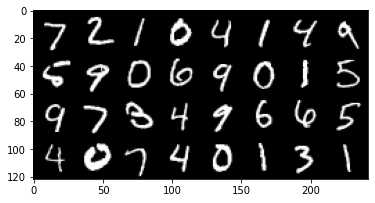

In [14]:
show_imgrid(x,y,nrow=8)

### Load Model

In [15]:
#p_model = '/mnt/data/experiments/CN/mnist/mnist_CapsNet_2022_05_17_13_28_17/ckpts/model_150.ckpt'
p_model = '/mnt/data/experiments/CN_cross/mnist/mnist_CapsNetCross_2022_05_19_15_45_37/ckpts/model_150.ckpt'

In [36]:
CN = CapsNetCross()
CN.load_state_dict(torch.load(p_model))
CN.eval()

CapsNetCross(
  (backbone): Backbone(
    (layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (7): ReLU(inplace=True)
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
      (10): ReLU(inplace=True)
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (primcaps): PrimaryCaps(
    (dw_conv2d): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=valid, groups=128)
  )
  (squas

In [37]:
y_pred, x_reg = CN(x)

print(y_pred.shape, x_reg.shape)

torch.Size([32, 16, 8]) torch.Size([32, 10, 16])
torch.Size([32, 10, 16]) torch.Size([32, 1, 28, 28])


tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


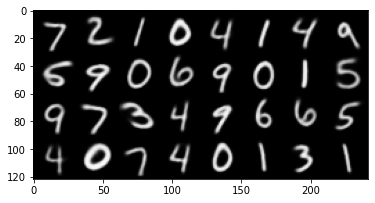

In [38]:
show_imgrid(x_reg,y,nrow=8)

In [39]:
u_h, x_rec, u_l, bb = CN.forward_pc_study(x)

print('Backbone Shape:       {}'.format(bb.shape))
print('PrimeCaps Shape:      {}'.format(u_l.shape))
print('ClassCaps Shape:      {}'.format(u_h.shape))
print('Reconstruction Shape: {}'.format(x_rec.shape))

Backbone Shape:       torch.Size([32, 128, 9, 9])
PrimeCaps Shape:      torch.Size([32, 16, 8])
ClassCaps Shape:      torch.Size([32, 10, 16])
Reconstruction Shape: torch.Size([32, 1, 28, 28])


In [40]:
mat = u_l[0].cpu().detach().numpy()

u_l[0].shape, u_l[0].max(), u_l[0].min()

(torch.Size([16, 8]),
 tensor(11.3312, grad_fn=<MaxBackward1>),
 tensor(-19.5590, grad_fn=<MinBackward1>))

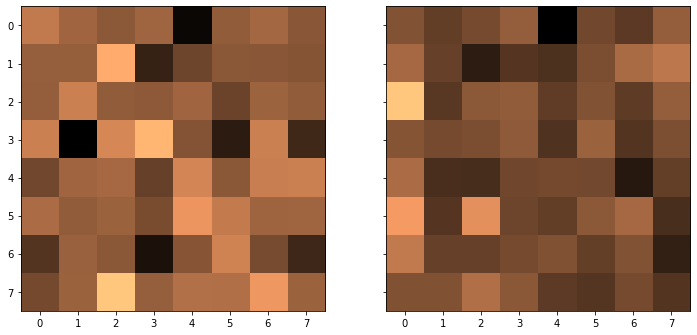

In [41]:
show_pc_vals(pc=u_l[7], ncol=2, cmap="copper", figsize=(12,50))

torch.Size([16, 8])
tensor(15.8443, grad_fn=<MaxBackward1>) tensor(3.6173, grad_fn=<MinBackward1>) torch.Size([16, 1])


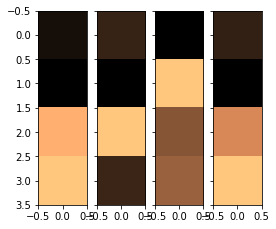

In [46]:
print(u_l[4].shape)

u_norm = u_l[5].norm(dim=1,keepdim=True)

print(u_norm.max(), u_norm.min(), u_norm.shape)

show_pc_vals(pc=u_norm , ncol=4, cmap="copper", figsize=(4,8))

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


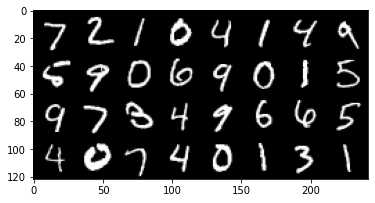

In [58]:
show_imgrid(x,y,nrow=8)

In [59]:
# test same numbers

# generate norm over capsule dimension
# subtract values of 2 inputs elementwise
# generate norm over dims for scarlar output -> maybe some better way?

n1 = u_l[4].norm(dim=1)
n2 = u_l[6].norm(dim=1)

print(n1.norm(), n2.norm())
print((n1-n2).norm())

n3 = u_l[0].norm(dim=1)

print(n1.norm(), n3.norm())
print((n1-n3).norm())

print((n3-n1).norm())
print((u_l[4]-u_l[0]).norm())



tensor(48.2196, grad_fn=<CopyBackwards>) tensor(48.2174, grad_fn=<CopyBackwards>)
tensor(12.1213, grad_fn=<CopyBackwards>)
tensor(48.2196, grad_fn=<CopyBackwards>) tensor(48.1512, grad_fn=<CopyBackwards>)
tensor(28.0767, grad_fn=<CopyBackwards>)
tensor(28.0767, grad_fn=<CopyBackwards>)
tensor(62.2522, grad_fn=<CopyBackwards>)


In [60]:
calc_pc_delta(pc1=u_l[4], pc2=u_l[6])

tensor(12.1213, grad_fn=<CopyBackwards>)

### SHow Transforms 

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


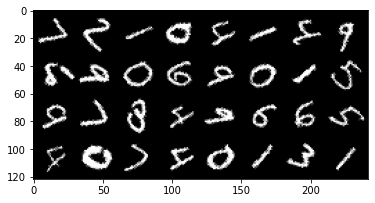

In [61]:
# https://pytorch.org/vision/stable/transforms.html
x_tf = TF.rotate(x, -50)

show_imgrid(x_tf,y,nrow=8)

torch.Size([32, 10, 16]) torch.Size([32, 1, 28, 28])
tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


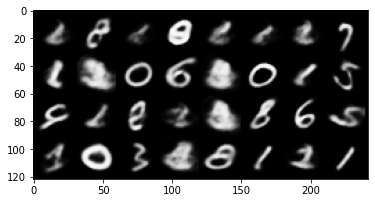

In [62]:
u_h_tf, x_rec_tf, u_l_tf, bb_tf = CN.forward_pc_study(x_tf)

print(y_pred.shape,  x_rec_tf.shape)

show_imgrid( x_rec_tf,y,nrow=8)

In [63]:
idx = 6

calc_pc_delta(pc1=u_l[idx], pc2=u_l_tf[idx])

tensor(20.8726, grad_fn=<CopyBackwards>)

In [64]:
calc_pc_delta(pc1=u_l, pc2=u_l_tf)

tensor([14.3608, 14.9603,  8.8717, 10.4224, 18.1672, 11.7324, 20.8726, 13.7650,
        19.0564, 14.3792,  7.9272, 10.7832, 16.7269, 11.0183,  9.6604, 13.7007,
        17.8263, 19.6125, 17.0173, 13.0394, 15.3537, 10.1681,  9.4516, 12.9701,
        17.2099, 13.0247, 12.9597, 19.6621, 10.8386, 14.7416, 12.0990, 13.6701],
       grad_fn=<CopyBackwards>)

### random input

torch.Size([1, 1, 28, 28])


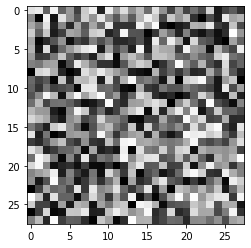

In [65]:
torch.manual_seed(42)

x_rand = torch.rand(1,1,28,28)
#x_rand = torch.randn(1,1,28,28)

print(x_rand.shape)

show_imgrid(x_rand,nrow=1)

In [66]:
u_h_rand, x_rec_rand, u_l_rand, bb_rand = CN.forward_pc_study(x_rand)

print(u_l_rand.shape)

torch.Size([1, 16, 8])


In [67]:
calc_pc_delta(pc1=u_l, pc2=u_l_rand)

tensor([28.7539, 25.4015, 26.8617, 27.1172, 16.9926, 26.2713, 21.2000, 23.8376,
        17.2966, 27.2841, 25.6202, 30.0513, 24.5787, 26.4262, 24.8709, 19.9882,
        24.3696, 31.5305, 26.7535, 18.4585, 22.8075, 24.8059, 21.6101, 23.5670,
        14.3199, 27.3108, 26.8505, 14.3603, 28.3671, 25.0496, 22.6772, 24.7606],
       grad_fn=<CopyBackwards>)

torch.Size([16, 1])


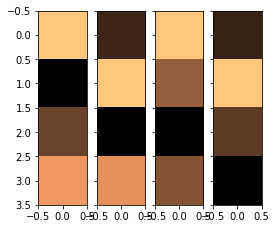

In [80]:
u_norm_rand = u_l_rand.norm(dim=-1,keepdim=True).squeeze(0)

print(u_norm_rand.shape)

show_pc_vals(pc=u_norm_rand , ncol=4, cmap="copper", figsize=(4,4))

### KLD

In [81]:
def test(P,Q):
    P = P.norm(dim=-1) 
    Q = Q.norm(dim=-1)
    #kld =(P * (P / Q).log()).sum()
    #return kld
    print(P.sum(), Q.sum())

In [82]:
idx = 6
print(calc_pc_norm_kld(pc2=u_l[idx], pc1=u_l_tf[idx]))
#print(calc_pc_delta(pc1=u_l[idx], pc2=u_l_tf[idx]))
print(test(Q=u_l[idx], P=u_l_tf[idx]))

tensor(4.0112, grad_fn=<KlDivBackward0>)
tensor(167.8191, grad_fn=<SumBackward0>) tensor(183.6647, grad_fn=<SumBackward0>)
None


#### Multitransform

In [83]:
idx = 9

torch.Size([1, 1, 28, 28])


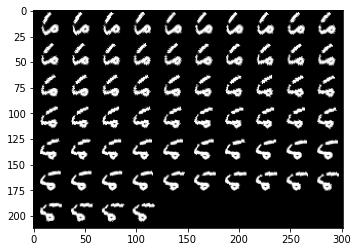

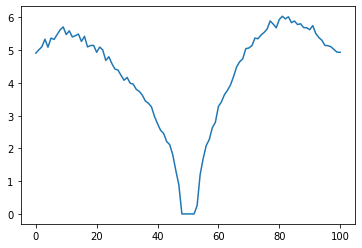

In [84]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_rot(x_aff,y_aff, range=[-50.,50.,1])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)

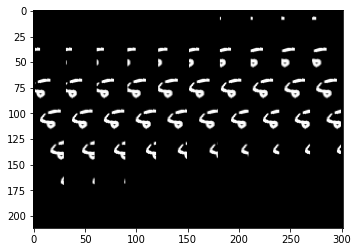

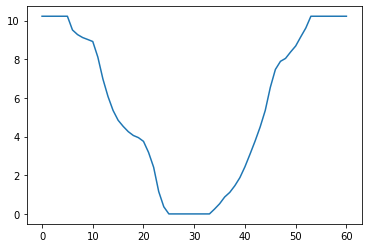

In [85]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_xtrans(img=x_aff, target=y_aff, range=[-30.,30.,1])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)

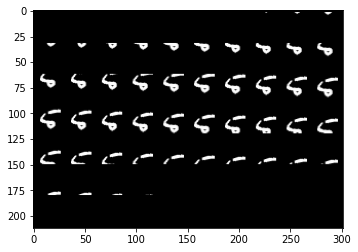

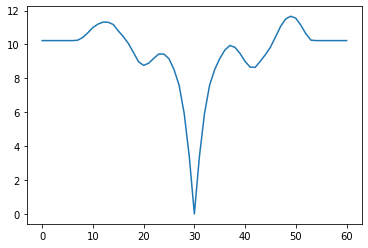

In [86]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_ytrans(img=x_aff, target=y_aff, range=[-30.,30.,1])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)

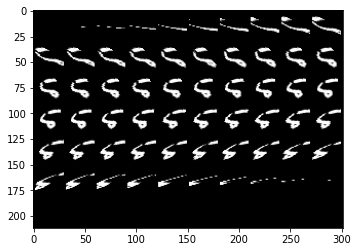

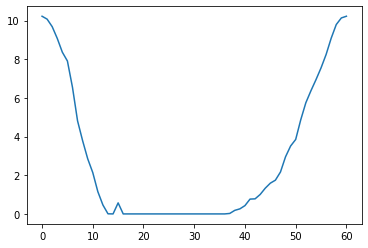

In [87]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_shear(img=x_aff, target=y_aff, range=[-90.,90.,3])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)

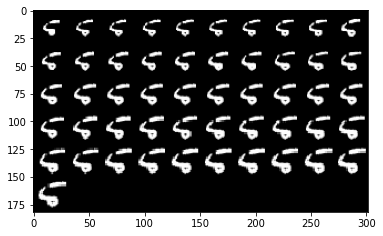

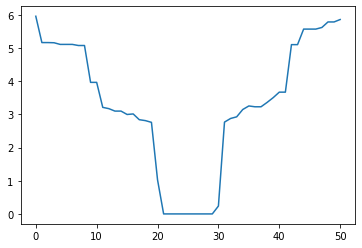

In [88]:
x_aff = x[(idx-1):idx]
y_aff = y[(idx-1):idx]

x_rot, y_rot = affine_scale(img=x_aff, target=y_aff, range=[0.75,1.25,0.01])

show_imgrid(x_rot,y_rot,nrow=10)

norm_delta = calc_pc_delta(pc1=x_aff, pc2=x_rot)


norm_delta = norm_delta.squeeze(-1).detach().numpy()
norm_delta.shape

plt_lin(norm_delta)